In [1]:
import tensorflow as tf
import numpy as np
from math import sqrt
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
import sys

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

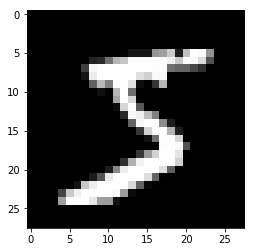

In [2]:
# load data and plot one of them
mnist = input_data.read_data_sets('MNIST_DATA', one_hot=True, validation_size=0)
img = mnist.train.images[0]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [3]:
# utitlity functions

def put_kernels_on_grid (kernel, pad = 1):

    '''Visualize conv. filters as an image (mostly for the 1st layer).
    Arranges filters into a grid, with some paddings between adjacent filters.
    Args:
    kernel:            tensor of shape [Y, X, NumChannels, NumKernels]
    pad:               number of black pixels around each filter (between them)
    Return:
    Tensor of shape [1, (Y+2*pad)*grid_Y, (X+2*pad)*grid_X, NumChannels].
    '''
    
    
    # get shape of the grid. NumKernels == grid_Y * grid_X
    def factorization(n):
        for i in range(int(sqrt(float(n))), 0, -1):
            if n % i == 0:
                if i == 1: print('Who would enter a prime number of filters')
                return (i, int(n / i))

        
    (grid_Y, grid_X) = factorization (kernel.get_shape()[3].value)
    #print ('grid: %d = (%d, %d)' % (kernel.get_shape()[3].value, grid_Y, grid_X))

    x_min = tf.reduce_min(kernel)
    x_max = tf.reduce_max(kernel)
    kernel = (kernel - x_min) / (x_max - x_min)

    # pad X and Y
    x = tf.pad(kernel, tf.constant( [[pad,pad],[pad, pad],[0,0],[0,0]] ), mode = 'CONSTANT')

    # X and Y dimensions, w.r.t. padding
    Y = kernel.get_shape()[0] + 2 * pad
    X = kernel.get_shape()[1] + 2 * pad

    channels = kernel.get_shape()[2]

    # put NumKernels to the 1st dimension
    x = tf.transpose(x, (3, 0, 1, 2))
    # organize grid on Y axis
    x = tf.reshape(x, tf.stack([grid_X, Y * grid_Y, X, channels]))

    # switch X and Y axes
    x = tf.transpose(x, (0, 2, 1, 3))
    # organize grid on X axis
    x = tf.reshape(x, tf.stack([1, X * grid_X, Y * grid_Y, channels]))

    # back to normal order (not combining with the next step for clarity)
    x = tf.transpose(x, (2, 1, 3, 0))

    # to tf.image_summary order [batch_size, height, width, channels],
    #   where in this case batch_size == 1
    x = tf.transpose(x, (3, 0, 1, 2))

    # scaling to [0, 255] is not necessary for tensorboard
    return x


def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        

In [4]:


def conv_layer(input, name, kshape, strides=[1, 1, 1, 1]):
    with tf.variable_scope(name):
        with tf.name_scope('W'):
            W = tf.get_variable(name='W', shape=kshape,
                                initializer=tf.contrib.layers.xavier_initializer(uniform=False))
            variable_summaries(W)
        with tf.name_scope('bias'):
            b = tf.get_variable(name='b', shape=kshape[3],
                                initializer=tf.contrib.layers.xavier_initializer(uniform=False))
            variable_summaries(b)
        out = tf.nn.conv2d(input, W, strides=strides, padding='SAME')
        out = tf.nn.bias_add(out, b)
        out = tf.nn.relu(out)
        
        #temp_ = tf.reshape(out, [-1, 28, 28, 1])
        temp_ = tf.transpose(out, perm=[3, 1, 2, 0])
        # if the bach size is more than one, just save the first one
        temp_ = temp_[:, :, :, 0:1]
        print(temp_)
        tf.summary.histogram('activations', out)
        tf.summary.image('activations', temp_, 20)
        
        grid = put_kernels_on_grid (W)
        tf.summary.image('kernels', grid, max_outputs=1)
        

        return out
    

def deconv_layer(input, name, kshape, n_outputs, stride=[1, 1]):
    with tf.variable_scope(name):
        
        
        out = tf.contrib.layers.conv2d_transpose(input, 
                                                 num_outputs=n_outputs, 
                                                 kernel_size=kshape, 
                                                 stride=stride, 
                                                 padding='SAME', 
                                                 weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                                                 biases_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                                                 activation_fn=tf.nn.relu)
        
        tf.summary.histogram('deconve_activations', out)
        return out

def p_deconv_layer (input, output_channel_size, filter_size_h, filter_size_w,
                   stride_h, stride_w, init_w, init_b, layer_name, 
                   dtype=tf.float32, data_format="NHWC", padding='VALID'):
    with tf.variable_scope(layer_name):
      #calculation of the output_shape:
      if data_format == "NHWC":
        input_channel_size = input.get_shape().as_list()[3]
        input_size_h = input.get_shape().as_list()[1]
        input_size_w = input.get_shape().as_list()[2]
        stride_shape = [1, stride_h, stride_w, 1]
        if padding == 'VALID':
          output_size_h = (input_size_h - 1)*stride_h + filter_size_h
          output_size_w = (input_size_w - 1)*stride_w + filter_size_w
        elif padding == 'SAME':
          output_size_h = (input_size_h - 1)*stride_h + 1
          output_size_w = (input_size_w - 1)*stride_w + 1
        else:
          raise ValueError("unknown padding")
        output_shape = tf.stack([tf.shape(input)[0], 
                                output_size_h, output_size_w, 
                                output_channel_size])
      elif data_format == "NCHW":
        input_channel_size = input.get_shape().as_list()[1]
        input_size_h = input.get_shape().as_list()[2]
        input_size_w = input.get_shape().as_list()[3]
        stride_shape = [1, 1, stride_h, stride_w]
        if padding == 'VALID':
          output_size_h = (input_size_h - 1)*stride_h + filter_size_h
          output_size_w = (input_size_w - 1)*stride_w + filter_size_w
        elif padding == 'SAME':
          output_size_h = (input_size_h - 1)*stride_h + 1
          output_size_w = (input_size_w - 1)*stride_w + 1
        else:
          raise ValueError("unknown padding")
        output_shape = tf.stack([tf.shape(input)[0], 
                                output_channel_size, 
                                output_size_h, output_size_w])
      else:
        raise ValueError("unknown data_format")

      #creating weights:
      shape = [filter_size_h, filter_size_w, 
               output_channel_size, input_channel_size]
      W_upconv = tf.get_variable("w", shape=shape, dtype=dtype,
                                 initializer=init_w)
      
      shape=[output_channel_size]
      b_upconv = tf.get_variable("b", shape=shape, dtype=dtype, 
                                 initializer=init_b)
      
      upconv = tf.nn.conv2d_transpose(input, W_upconv, output_shape, stride_shape,
                                      padding=padding,
                                      data_format=data_format)
      output = tf.nn.bias_add(upconv, b_upconv, data_format=data_format)
      
      #Now output.get_shape() is equal (?,?,?,?) which can become a problem in the 
      #next layers. This can be repaired by reshaping the tensor to its shape:
      output = tf.reshape(output, output_shape)
      #now the shape is back to (?, H, W, C) or (?, C, H, W)
      
      return output
    
def get_autoencoder_graph(input_images, name):
    with tf.name_scope(name):
        # encoding part
        conv1 = conv_layer(input_images, name='conv1', kshape=[5, 5, 1, 20])
        
        # decoding part
        output_images = deconv_layer(conv1, name='devon1', kshape=[5, 5], n_outputs=1)
        tf.summary.image('output_images', output_images, 4)

        
        with tf.name_scope('cost'):
            cost = tf.reduce_mean(tf.square(tf.subtract(output_images, input_images)))
        tf.summary.scalar('cost', cost) 
        
        return cost, output_images


Tensor("my_conv_autoencoder/conv1/strided_slice:0", shape=(20, 28, 28, ?), dtype=float32)
('Epoch', 1, '/', 6, 'cost:', 0.13125893154957644)
('Epoch', 2, '/', 6, 'cost:', 0.005147539774576824)
('Epoch', 3, '/', 6, 'cost:', 0.001841567612524767)
('Epoch', 4, '/', 6, 'cost:', 0.0010543256422776424)
('Epoch', 5, '/', 6, 'cost:', 0.0007602565508568654)
('Epoch', 6, '/', 6, 'cost:', 0.0005666994772036553)
Optimization Finished
('cost on test data:', 0.000485867)


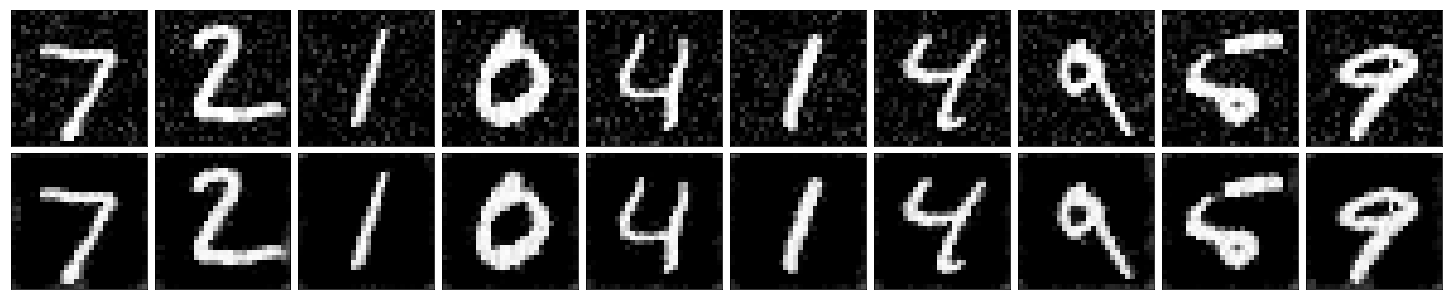

In [6]:
def main():
    
    # creat the log file directory
    if tf.gfile.Exists(FLAGS.log_dir):
        tf.gfile.DeleteRecursively(FLAGS.log_dir)
    tf.gfile.MakeDirs(FLAGS.log_dir)
    
     # to be able to rerun this cell, we need to reset the graph
    tf.reset_default_graph()

    
    def plot_reconstructed(sess, input_images, output_images):
        noise_factor = 0.1
        fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
        in_imgs = mnist.test.images[:10]
        noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)

        reconstructed = sess.run(output_images, feed_dict={input_images: noisy_imgs.reshape((10, 28, 28, 1))})

        for images, row in zip([noisy_imgs, reconstructed], axes):
            for img, ax in zip(images, row):
                ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

        fig.tight_layout(pad=0.1)
    
    
    def feed_dict(train_flag):
        #Make a TensorFlow feed_dict: maps data onto Tensor placeholders
        if train_flag == True:
            X, y = mnist.train.next_batch(FLAGS.batch_size)
        else:
            X, y = mnist.test.images, mnist.test.labels
        images = X.reshape((-1, 28, 28, 1))
        return {input_images: images}
    

    # input and target placeholders
    with tf.name_scope('Inputs'):
        input_images = tf.placeholder(tf.float32, (None, 28, 28, 1), name="input_images")
        tf.summary.image('input_images', input_images, 4)
    
    cost, output_images = get_autoencoder_graph(input_images, name='my_conv_autoencoder')
        
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate).minimize(cost)

   
    merged_summary = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.log_dir + '/train', graph=tf.get_default_graph())
    test_writer = tf.summary.FileWriter(FLAGS.log_dir + '/test')


    #with tf.Session() as sess:
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    n_batches = int(mnist.train.num_examples / FLAGS.batch_size)
    for epoch in range(FLAGS.max_epochs):
        avg_cost = 0            

        for i in range(n_batches):
            _, c, summary = sess.run([optimizer, cost, merged_summary], feed_dict=feed_dict(FLAGS.train))
            avg_cost += c/n_batches

        if epoch % 1 ==0:
            train_writer.add_summary(summary, epoch)    

        print('Epoch', epoch+1, '/', FLAGS.max_epochs, 'cost:', avg_cost)
    print('Optimization Finished')

    print('cost on test data:', sess.run(cost, feed_dict=feed_dict(not FLAGS.train)))
    plot_reconstructed(sess, input_images, output_images)
     
    return sess, output_images, input_images


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--max_epochs', type=int, default=6,
                      help='Number of steps to run trainer.')
    parser.add_argument('--batch_size', type=int, default=100,
                       help='Batch size.')
    parser.add_argument('--learning_rate', type=float, default=0.0001,
                      help='Initial learning rate')
    parser.add_argument('--train', type=bool, default=True,
                       help='Set True for trainign phase and False in testing phase')
    parser.add_argument(
      '--data_dir',
      type=str,
      default=os.path.join('.','input_data'),
      help='Directory for storing input data')
    parser.add_argument(
      '--log_dir',
      type=str,
      default=os.path.join('.',
                           'log'),
      help='Summaries log directory')
    FLAGS, unparsed = parser.parse_known_args()
    #sess = tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)    
    sess, output_images, input_images = main()

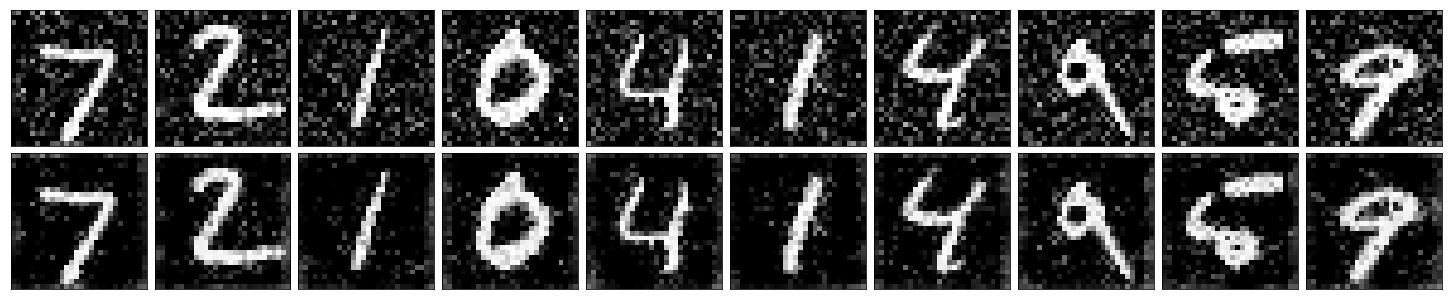

In [10]:
noise_factor = 0.2
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0.0, 1.)

reconstructed = sess.run(output_images, feed_dict={input_images: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [165]:
tf.trainable_variables()

def get_variable(name):
    name += ':0' # the weight names have :0 at their end
    var = [v for v in tf.trainable_variables() if v.name==name]
    return var[0] # i'm returning just the first variable with this name

v = get_variable('devon1/Conv2d_transpose/weights').eval(session = sess)
print(v.shape)
print(v)


(5, 5, 1, 20)
[[[[ 6.50392324e-02 -2.22877134e-02 -2.51635145e-02 -2.06237882e-01
    -8.44018981e-02  7.87025094e-02 -1.60234403e-02 -1.33200437e-01
     9.75827798e-02  7.93902650e-02 -1.34472802e-01  1.30523697e-01
    -2.28309985e-02 -2.37194989e-02 -8.43503773e-02 -1.44294217e-01
     7.76919276e-02 -5.48509136e-02 -1.00189224e-01  8.97784438e-03]]

  [[ 1.64329082e-01  6.29756600e-02 -1.25393057e-02 -1.75735325e-01
     9.51369256e-02  5.13776392e-02  3.53251584e-02 -1.52258828e-01
    -2.62702182e-02 -7.60491267e-02  8.67869798e-03 -2.20838320e-02
    -2.72110831e-02  1.31123550e-02 -4.00744416e-02 -6.79988116e-02
    -5.67551404e-02  3.74931581e-02 -1.63992271e-01 -1.43407155e-02]]

  [[-4.77337725e-02 -2.36786138e-02 -2.36076247e-02  3.13478231e-01
    -5.64359464e-02 -2.47190073e-01 -4.70775092e-04 -5.52018546e-02
    -2.58224998e-02 -6.82984889e-02 -1.09521687e-01  1.11447610e-01
    -1.08174108e-01 -2.44220663e-02  2.98840143e-02  4.94119385e-03
    -1.64715946e-02 -5.52424

In [163]:
tf.trainable_variables()

[<tf.Variable 'conv1/W:0' shape=(5, 5, 1, 20) dtype=float32_ref>,
 <tf.Variable 'conv1/b:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'devon1/Conv2d_transpose/weights:0' shape=(5, 5, 1, 20) dtype=float32_ref>,
 <tf.Variable 'devon1/Conv2d_transpose/biases:0' shape=(1,) dtype=float32_ref>]